In [1]:
import numpy as np
import matplotlib.pyplot as plt

from braket.ahs.atom_arrangement import AtomArrangement

from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from utils import show_register, show_global_drive, show_final_avg_density, get_drive, get_avg_density

from braket.devices import LocalSimulator

## 1D $Z_{2}$

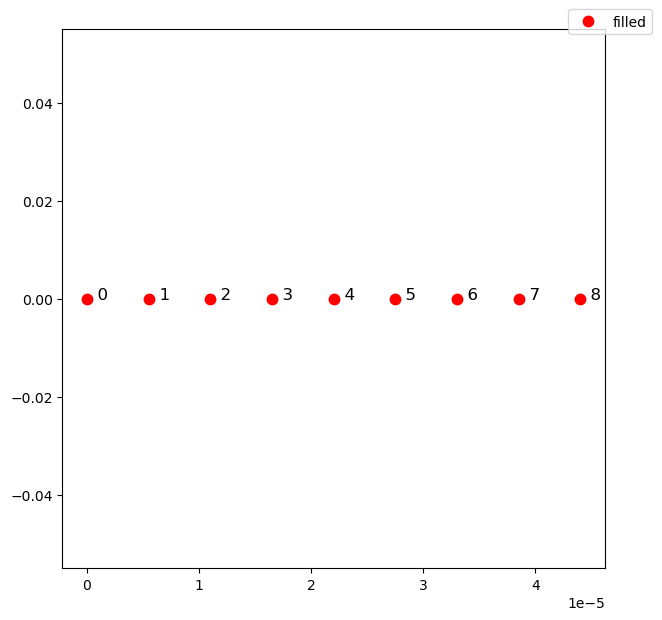

In [2]:
register = AtomArrangement()
separation = 5.5e-6  # in meters 
num_atoms = 9

for k in range(num_atoms):
    register.add([k * separation, 0])
    
show_register(register)

In [3]:
amplitude_min = 0
amplitude_max = 6.3e6  # rad / s
detuning_min = -6e6  # rad / s
detuning_max = 15e6  # rad / s

time_max = 4e-6  # s
time_ramp = 5e-7  # s

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]


drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)

array([<AxesSubplot:ylabel='amplitude [rad/s]'>,
       <AxesSubplot:ylabel='detuning [rad/s]'>,
       <AxesSubplot:xlabel='time [s]', ylabel='phase [rad]'>],
      dtype=object)

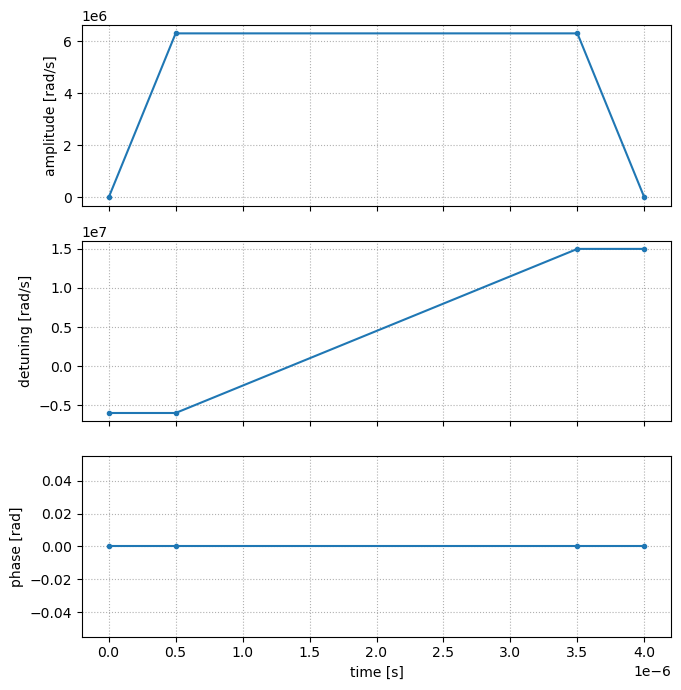

In [4]:
show_global_drive(drive)

In [5]:

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)


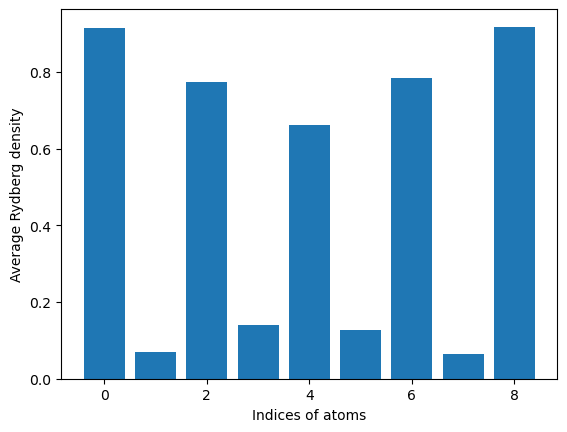

In [6]:
device = LocalSimulator("braket_ahs")
result = device.run(ahs_program, shots=1000).result()
show_final_avg_density(result)

In [7]:
def get_density_correlation_Z2(result):
    post_sequences = np.array([list(measurement.post_sequence) for measurement in result.measurements])
    return np.cov(post_sequences.T)

gij = get_density_correlation_Z2(result)

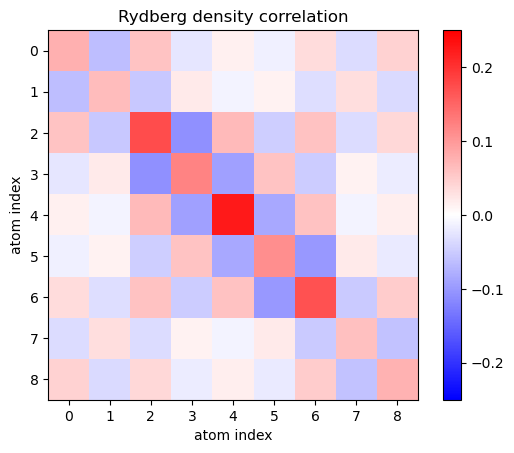

In [8]:
plt.imshow(gij, cmap='bwr', vmin=-0.25, vmax=+0.25)
plt.xticks(range(num_atoms), [f'{i}' for i in range(num_atoms)])
plt.xlabel("atom index")
plt.yticks(range(num_atoms), [f'{j}' for j in range(num_atoms)])
plt.ylabel("atom index")
plt.title('Rydberg density correlation')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()

### Submit to QPU

In [ ]:
import braket.ahs
import braket.ir.ahs
print(braket.ahs.__file__)
print(braket.ir.ahs.__file__)

In [ ]:
from braket.aws import AwsDevice

qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
print(qpu)

In [ ]:
import json
json.loads(qpu.properties.paradigm.json())

In [ ]:
# [Optional] We print values and detailed description of one particular section

section = qpu.properties.paradigm.lattice.geometry
print(type(section))
print(section)
print(section.__doc__)

In [ ]:
# To ensure that the program complies with resolution-specific validation rules

discretized_ahs_program = ahs_program.discretize(qpu)

In [ ]:
# [Optional] Compare original and discretized AHS programs

for original, discretized in zip (
    ahs_program.hamiltonian.terms[0].amplitude.time_series.times(),
    discretized_ahs_program.hamiltonian.terms[0].amplitude.time_series.times(),
):
    print(original.__repr__(), discretized.__repr__())

In [ ]:
task = qpu.run(discretized_ahs_program_2D, shots=100)
print(task)

In [ ]:
# [Optional] We can investigate task metadata

task.metadata()

In [ ]:
result = task.result()

result_dict = dict(braket_results.json())

In [ ]:
# analyze results
show_final_avg_density(result)

In [ ]:
plt.imshow(gij, cmap='bwr', vmin=-0.25, vmax=+0.25)
plt.xticks(range(num_atoms), [f'{i}' for i in range(num_atoms)])
plt.xlabel("atom index")
plt.yticks(range(num_atoms), [f'{j}' for j in range(num_atoms)])
plt.ylabel("atom index")
plt.title('Rydberg density correlation')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()

## 2D Checkerboard 3x3 Phase

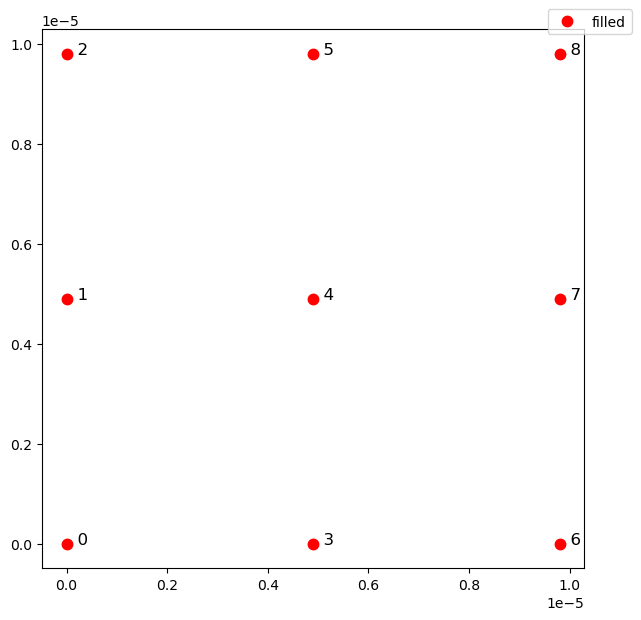

In [9]:
register_2D = AtomArrangement()
separation = 4.9e-6  # in meters 

for k in range(3):
    for l in range(3):
        register_2D.add((k * separation, l * separation))

show_register(register_2D)

In [10]:
amplitude_min = 0       
amplitude_max = 6.3e6

detuning_min = -3e6
detuning_max = 10e6

time_max = 4e-6
time_ramp = 10e-7

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]


drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)

In [11]:
ahs_program_2D = AnalogHamiltonianSimulation(
    register=register_2D, 
    hamiltonian=drive
)

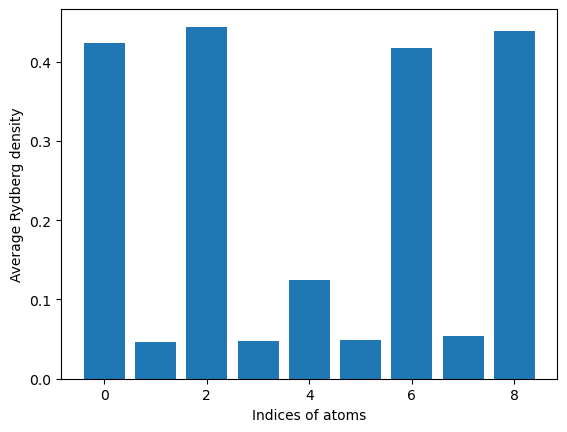

In [12]:
result_2D = device.run(ahs_program_2D, shots=1000, steps=200).result()
show_final_avg_density(result_2D)

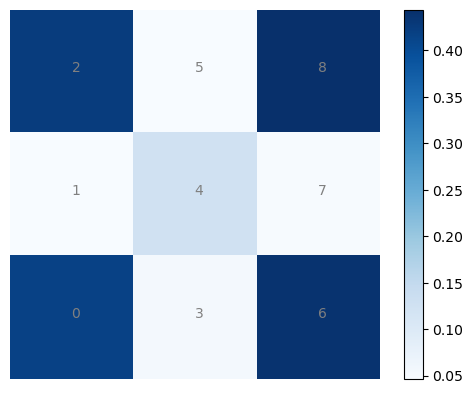

In [13]:
def plot_avg_density_grid(result, dim):
    fig, ax = plt.subplots(1)
    # get the average density into grid format with same indexes
    # as shown by `show_register()` function
    avg_density = get_avg_density(result)
    avg_density_grid = avg_density.reshape(*dim)
    # overlay indexes onto plotted average densities, making sure values
    # are in proper positions
    im = ax.imshow(avg_density_grid, cmap="Blues")
    grid = np.rot90(np.array([i for i in range(len(avg_density))]).reshape(3,3), k=1)
    for (j,i),label in np.ndenumerate(grid):
        ax.text(i,j,label, color='grey')
    # turn off text on axes
    plt.axis('off')
    # add colorbar
    fig.colorbar(im);
    
plot_avg_density_grid(result_2D, (3,3))

### Submit to  QPU 

Removed most optional args + number of cells after exposure above

In [ ]:
discretized_ahs_program_2D = ahs_program_2D.discretize(qpu)

# [Optional] Compare original and discretized AHS programs

for original, discretized in zip (
    ahs_program_2D.hamiltonian.terms[0].amplitude.time_series.times(),
    discretized_ahs_program_discretized_2D.hamiltonian.terms[0].amplitude.time_series.times(),
):
    print(original.__repr__(), discretized.__repr__())
    
task = qpu.run(discretized_ahs_program_2D, shots=100)
print(task)

# [Optional] We can investigate task metadata

task.metadata()

result_2D = task.result()


In [ ]:
show_final_avg_density(result_2D)

In [ ]:
# Analyze Results 

plot_avg_density_grid(result_2D, (3,3))

## 5 x 3 Checkerboard

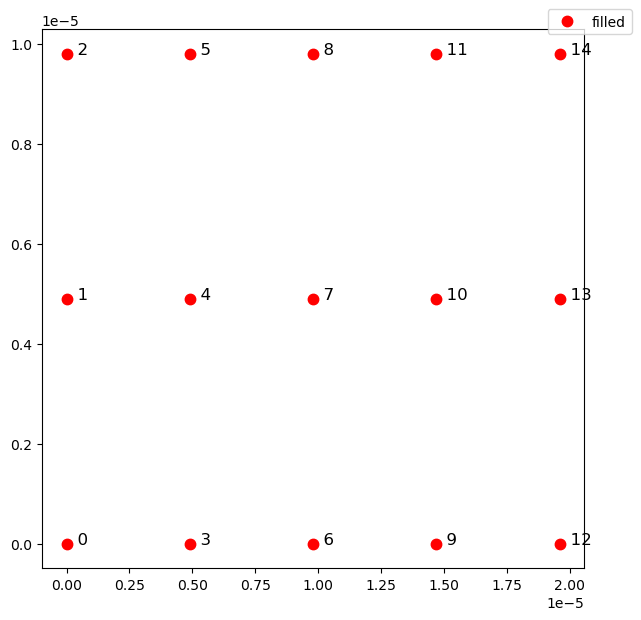

In [14]:
register_2D = AtomArrangement()
separation = 4.9e-6  # in meters 

for k in range(5):
    for l in range(3):
        register_2D.add((k * separation, l * separation))

show_register(register_2D)

In [ ]:
ahs_program_2D = AnalogHamiltonianSimulation(
    register=register_2D, 
    hamiltonian=drive
)

result_2D = device.run(ahs_program_2D, shots=100, steps=200).result()
show_final_avg_density(result_2D)

### Submit to QPU

In [ ]:
discretized_ahs_program_2D = ahs_program_2D.discretize(qpu)

# [Optional] Compare original and discretized AHS programs

for original, discretized in zip (
    ahs_program_2D.hamiltonian.terms[0].amplitude.time_series.times(),
    discretized_ahs_program_2D.hamiltonian.terms[0].amplitude.time_series.times(),
):
    print(original.__repr__(), discretized.__repr__())
    
task = qpu.run(discretized_ahs_program_2D, shots=100)
print(task)

# [Optional] We can investigate task metadata

task.metadata()

result_2D = task.result()

In [ ]:
show_final_avg_density(result_2D)

In [ ]:
plot_avg_density_grid(result_2D, (5,3))